In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from dynamics import ode
import time as time_lib
import multiprocessing
from utils import vecField,act,flowMap,fineIntegratorParallel,f

### Test on one initial condition

In [2]:
#Data
y0 = np.array([1,0,0.]) #initial values
t_0 = 0
t_f = 1

In [3]:
initial_time_bdf = time_lib.time()
sol_scipy = scipy.integrate.solve_ivp(f,[t_0,t_f],y0, method='BDF',rtol=1e-5,atol=1e-5)
final_time_bdf = time_lib.time()
sol_scipy_2 = scipy.integrate.solve_ivp(f,[t_0,t_f],y0=sol_scipy.y[:,-1], method='BDF',rtol=1e-5,atol=1e-5)

In [4]:
n_x = 10
n_t = 10

LB = -1.
UB = 1.
L = 5
y0 = np.array([1.,0.,0])
weight = np.random.uniform(low=LB,high=UB,size=(L))
bias = np.random.uniform(low=LB,high=UB,size=(L))

flow = flowMap(y0=y0,weight=weight,bias=bias,dt=1.,n_t=5,n_x=10,L=L,LB=LB,UB=UB,system="Rober",act_name="Tanh")
flow.approximate_flow_map()
time = np.linspace(0,t_f,1000)
sol_approximation = flow.plotOverTimeRange(sol_scipy.t)

final = flow.analyticalApproximateSolution(1.)
flow = flowMap(y0=final,weight=weight,bias=bias,dt=1.,n_t=5,n_x=10,L=L,LB=LB,UB=UB,system="Rober",act_name="Tanh")
flow.approximate_flow_map()
time = np.linspace(0,t_f,1000)
sol_approximation_2 = flow.plotOverTimeRange(sol_scipy_2.t)


In [5]:
'''for i in range(3):
    fig = plt.figure(dpi=600)
    plt.semilogx(sol_scipy.t,sol_scipy.y[i],'k-',label="BDF solution")
    plt.semilogx(sol_scipy.t,sol_approximation[i],'r--',label="Approximation")
    plt.title(fr"$y_{i}$")
    plt.legend()
    plt.show();'''

'for i in range(3):\n    fig = plt.figure(dpi=600)\n    plt.semilogx(sol_scipy.t,sol_scipy.y[i],\'k-\',label="BDF solution")\n    plt.semilogx(sol_scipy.t,sol_approximation[i],\'r--\',label="Approximation")\n    plt.title(fr"$y_{i}$")\n    plt.legend()\n    plt.show();'

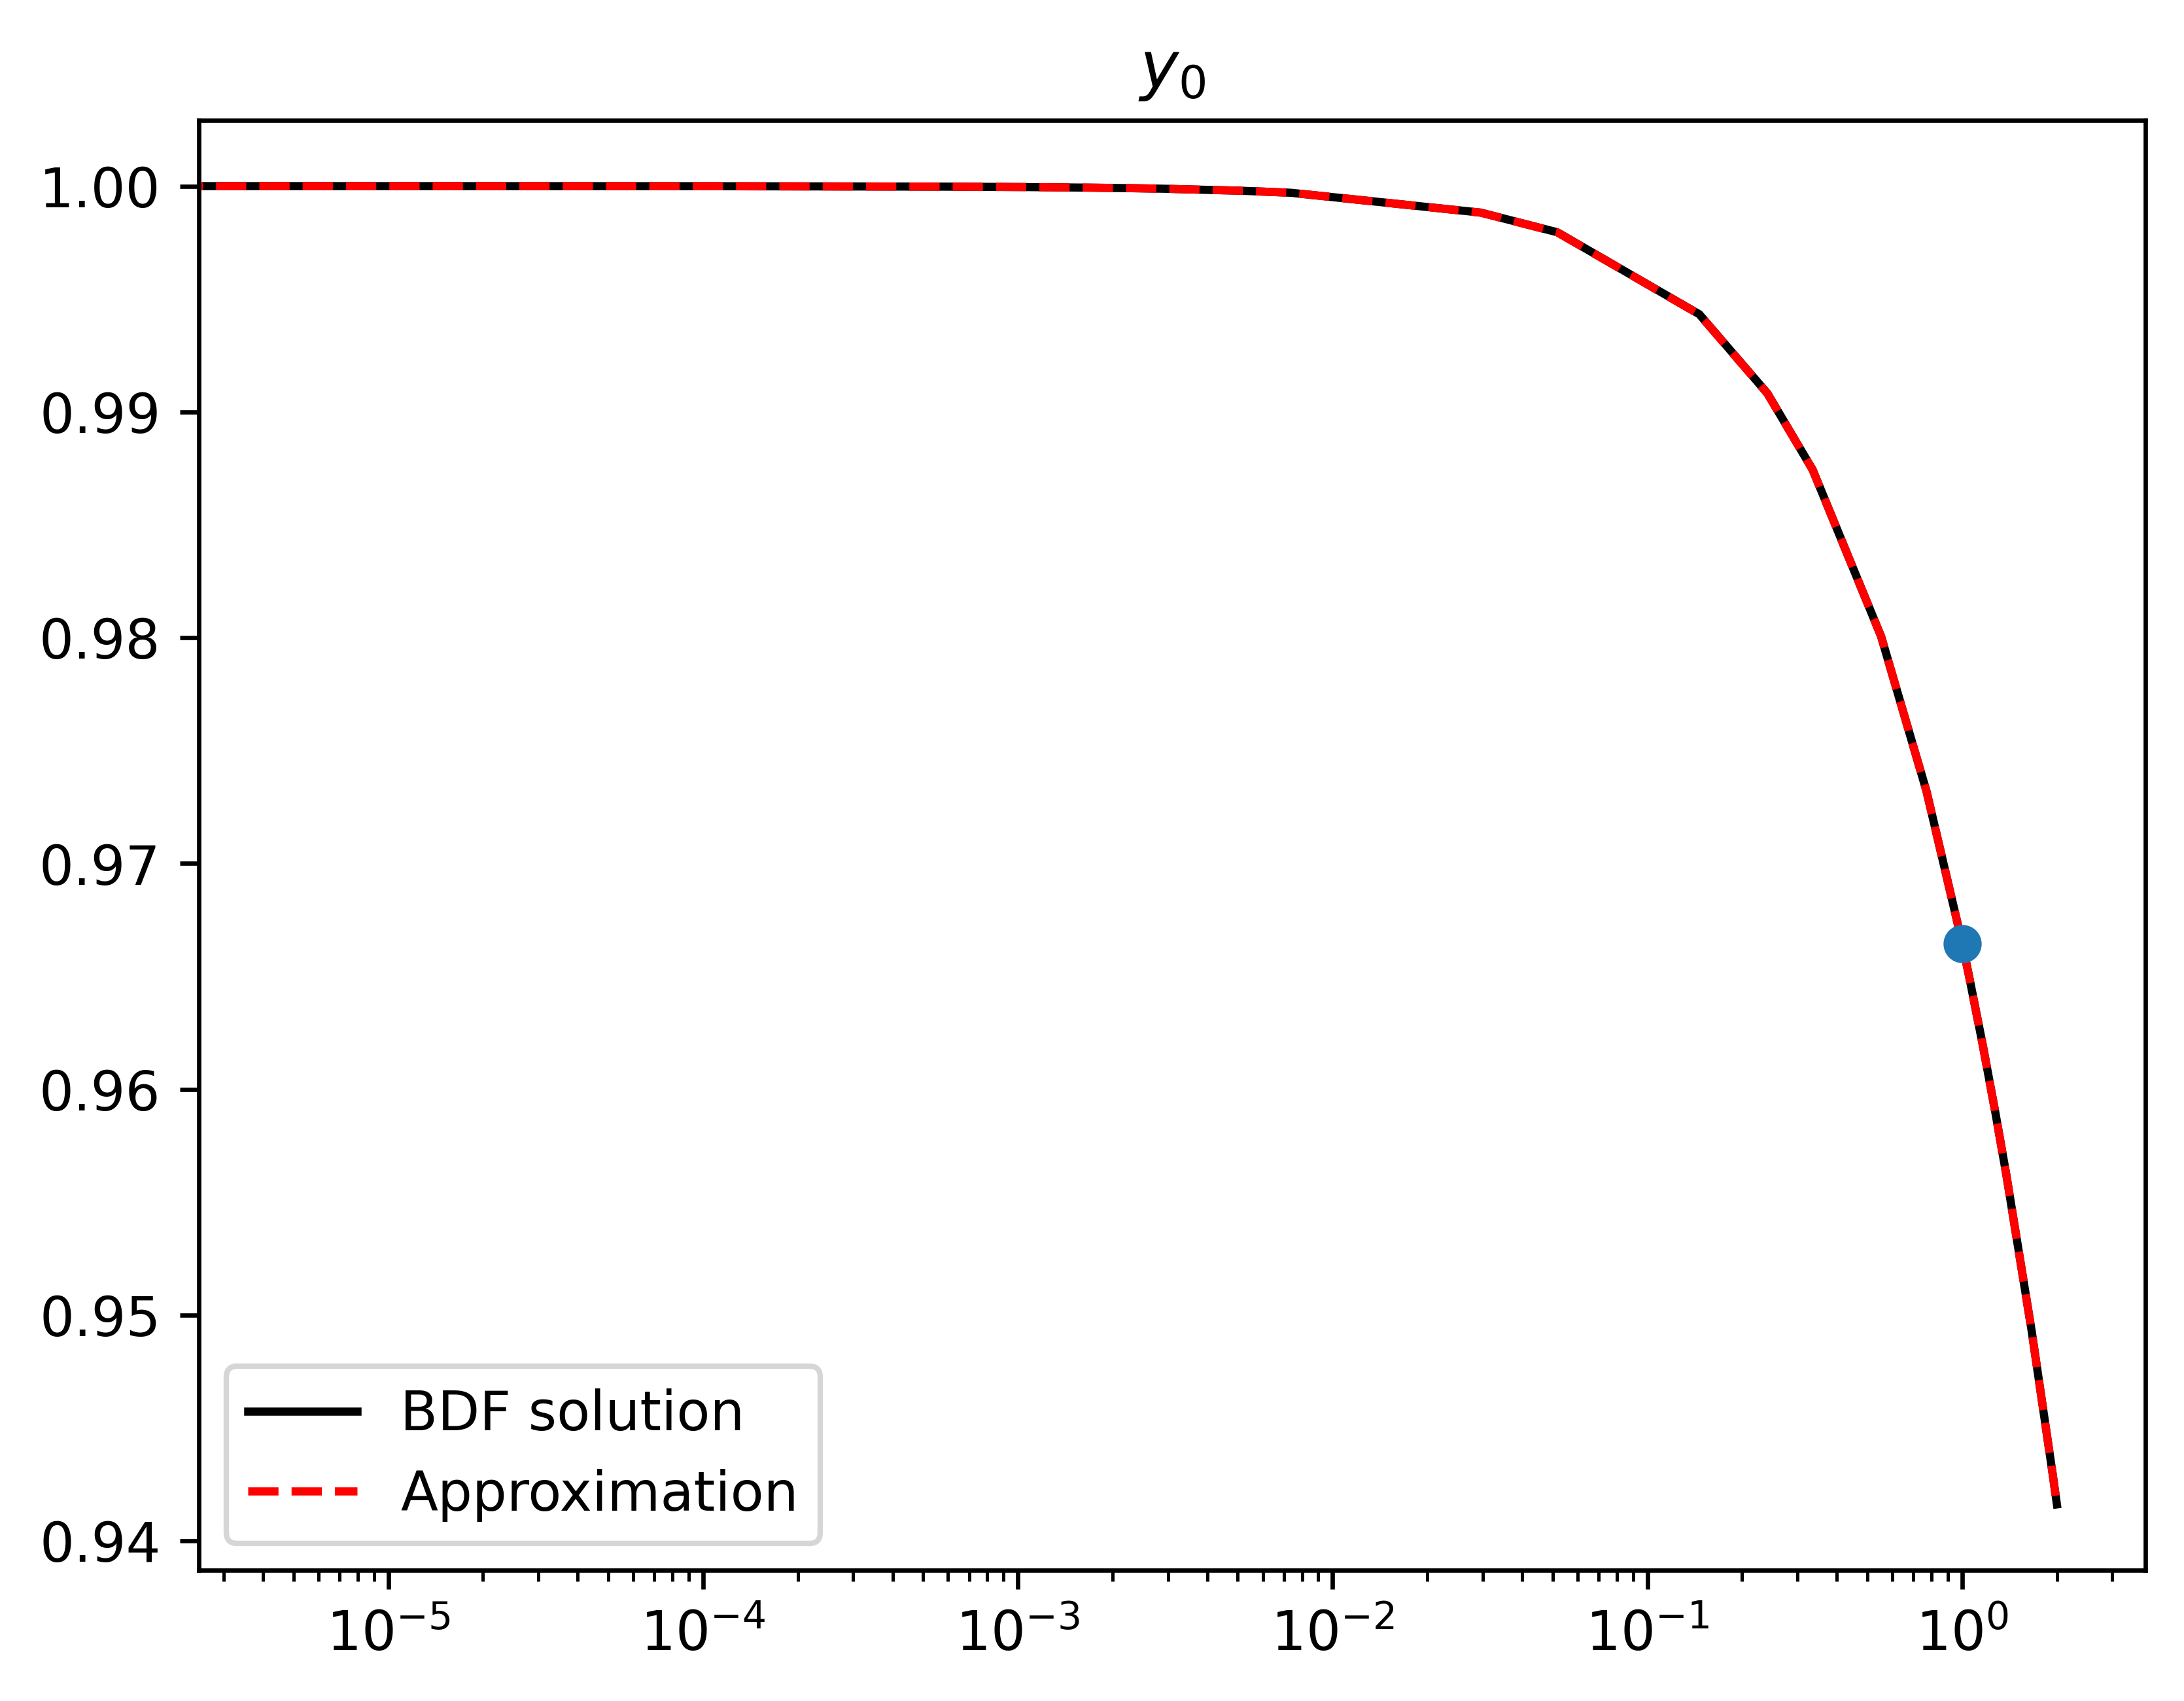

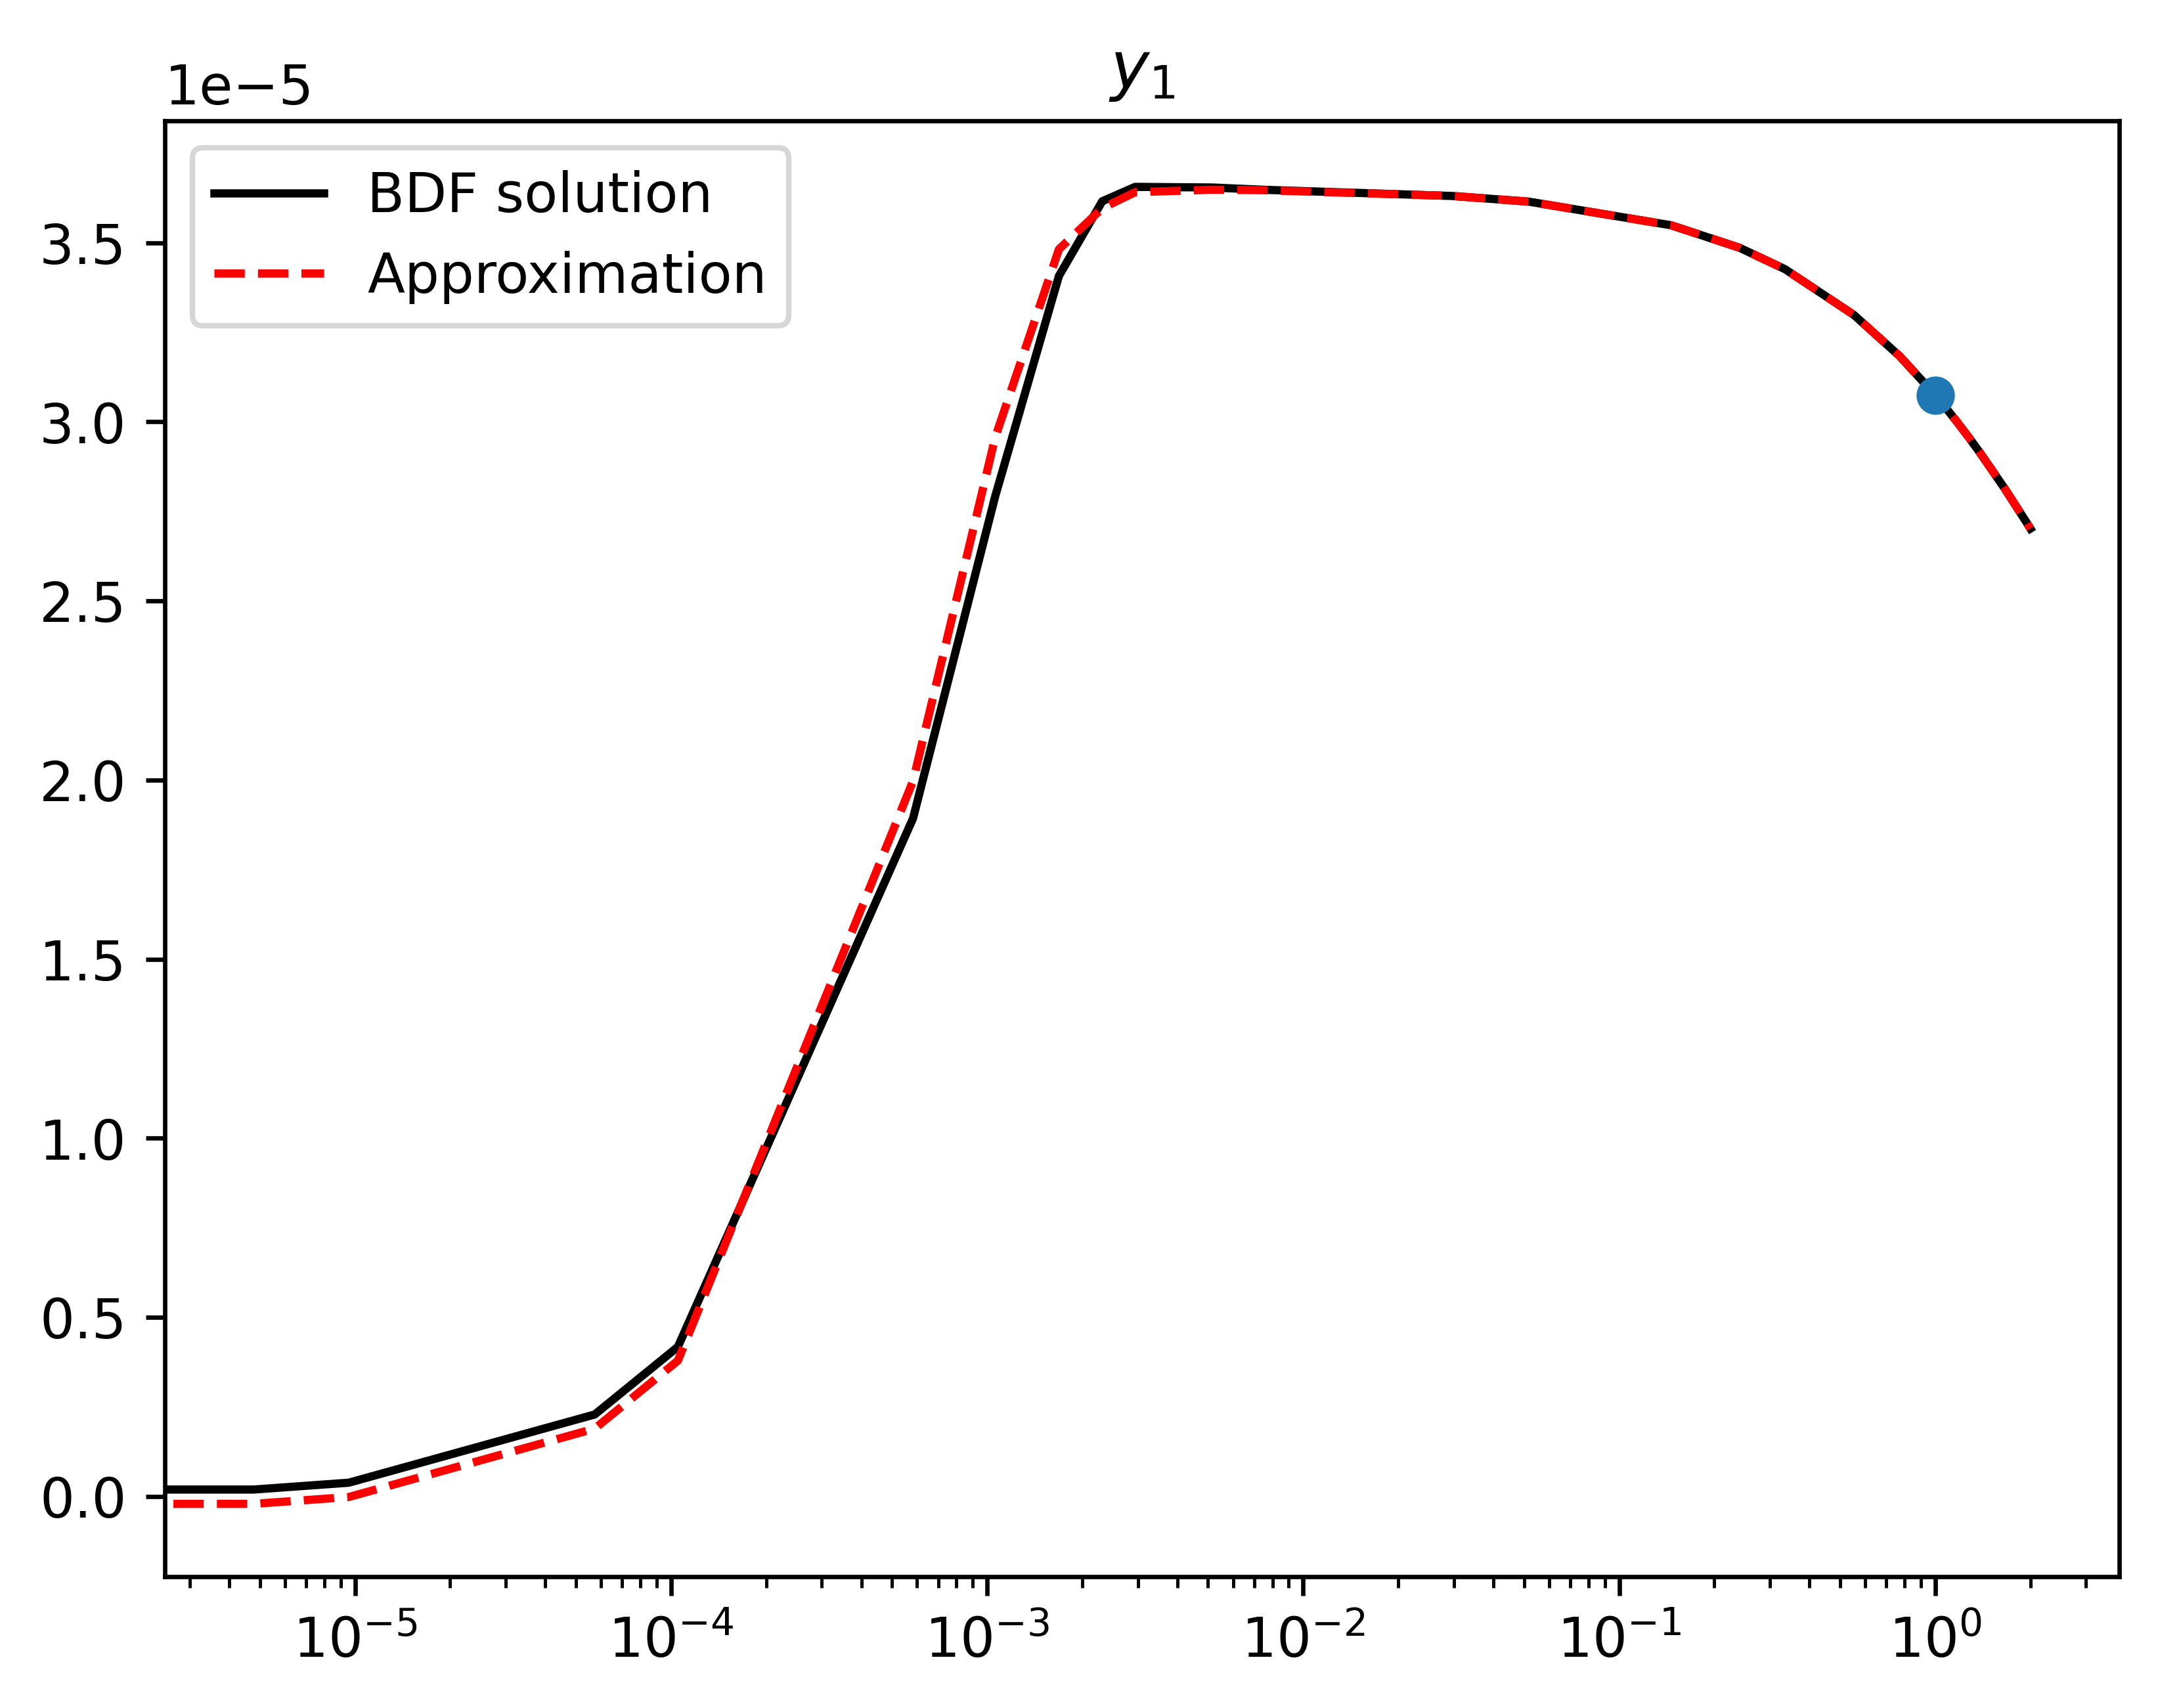

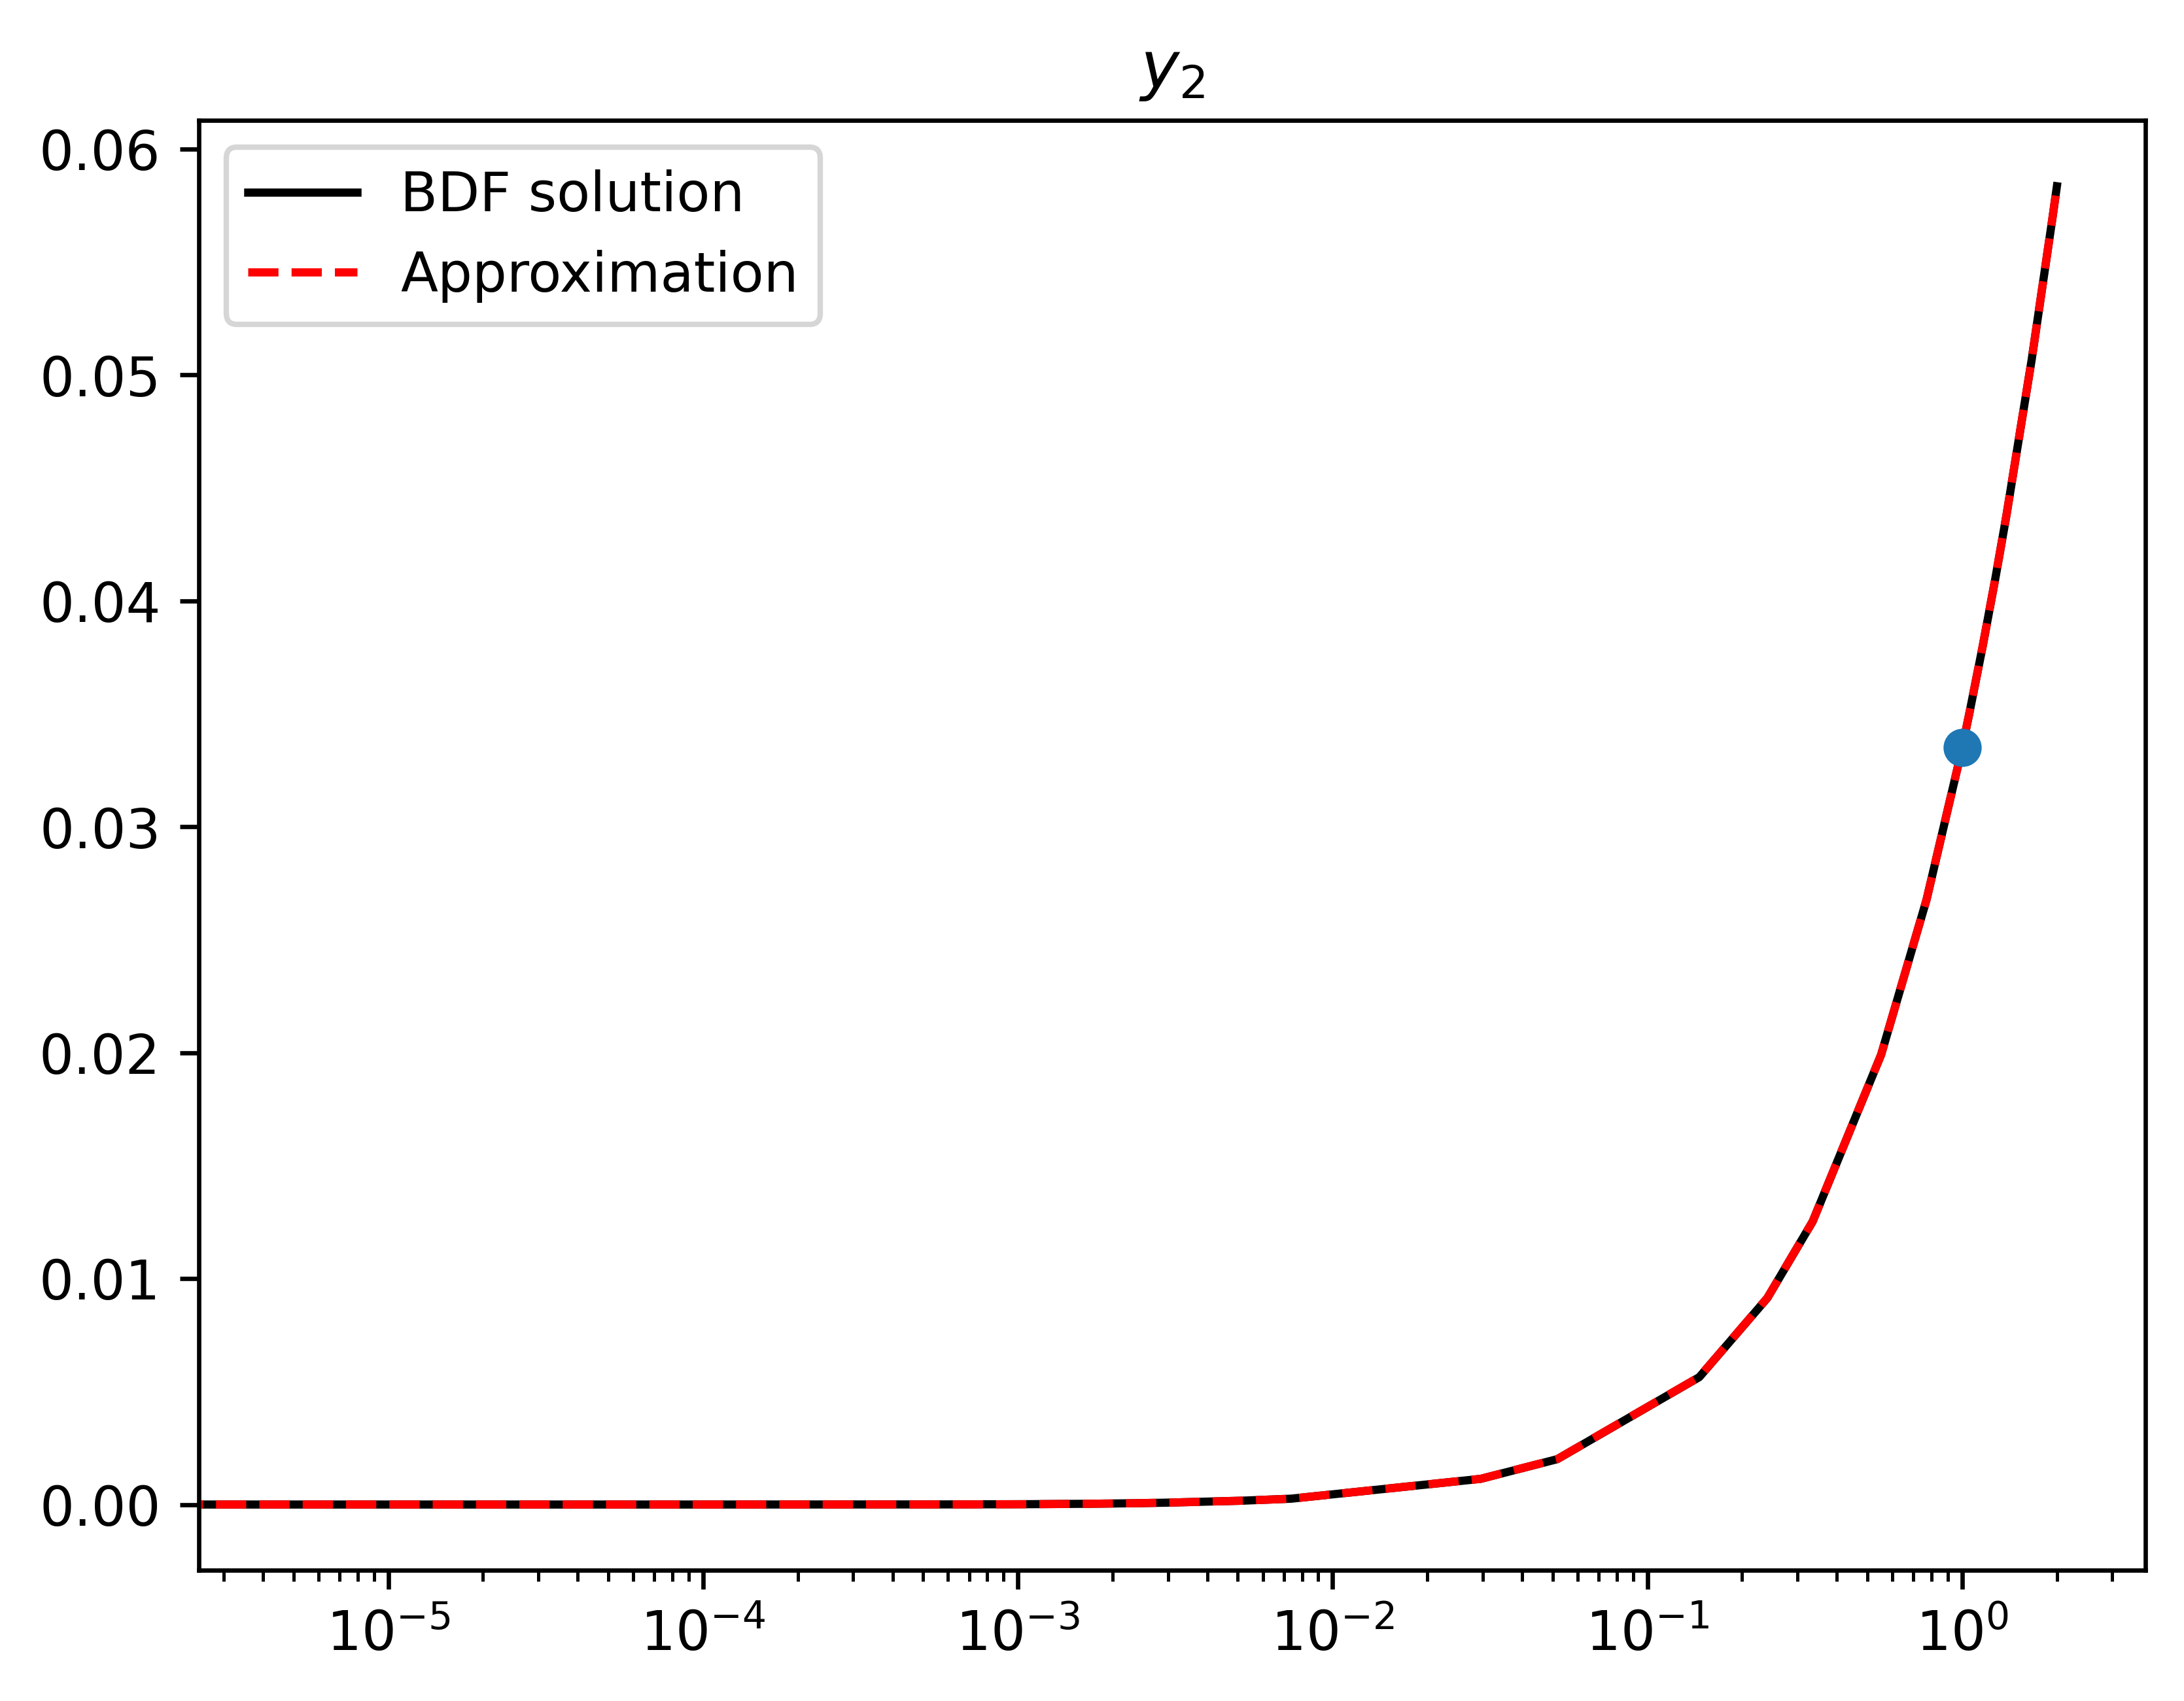

In [6]:
for i in range(3):
    fig = plt.figure(dpi=600)
    time = np.concatenate((sol_scipy.t,1+sol_scipy_2.t),axis=0)
    sol_sp = np.concatenate((sol_scipy.y,sol_scipy_2.y),axis=1)
    sol_net = np.concatenate((sol_approximation,sol_approximation_2),axis=1)
    
    plt.semilogx(time,sol_sp[i],'k-',label="BDF solution")
    plt.semilogx(time,sol_net[i],'r--',label="Approximation")
    plt.semilogx([1.],final[i],'o')
    plt.title(fr"$y_{i}$")
    plt.legend()
    plt.show();

In [7]:
print(f"The calculation with the NN took {flow.computational_time} seconds")
print(f"The calculation with BDF method took {final_time_bdf-initial_time_bdf} seconds")

The calculation with the NN took 0.006876945495605469 seconds
The calculation with BDF method took 0.013750076293945312 seconds


In [8]:
t_max = 1000
t = np.linspace(0,t_max,int(t_max)+1)
dts = np.diff(t)
system = "Rober"

In [9]:
def getCoarse(previous=[]):
    coarse_approx = np.zeros((len(t),3))
    coarse_approx[0] = y0
    
    if len(previous)==0:
        for i in range(len(coarse_approx)-1):
            flow = flowMap(y0=coarse_approx[i],weight=weight,bias=bias,dt=dts[i],n_t=5,n_x=5,L=L,LB=LB,UB=UB,system=system,act_name="Tanh")
            flow.approximate_flow_map()
            coarse_approx[i+1] = flow.analyticalApproximateSolution(dts[i])

    else:
        for i in range(len(previous)-1):
            flow = flowMap(y0=previous[i],weight=weight,bias=bias,dt=dts[i],n_t=5,n_x=5,L=L,LB=LB,UB=UB,system=system,act_name="Tanh")
            flow.approximate_flow_map()
            coarse_approx[i+1] = flow.analyticalApproximateSolution(dts[i])
            
    return coarse_approx
    
def getNextCoarse(y,i):
    flow = flowMap(y0=y,weight=weight,bias=bias,dt=dts[i],n_t=5,n_x=10,L=L,LB=LB,UB=UB,system=system,act_name="Tanh")
    flow.approximate_flow_map()
    return flow.analyticalApproximateSolution(dts[i])

In [10]:
import numba as nb

In [11]:
from numbalsoda import lsoda_sig, lsoda, dop853
from numba import njit, cfunc

In [12]:
@cfunc(lsoda_sig)
def f(t,y,dy,p):
    dy[0] =  -0.04*y[0] + 1e4 * y[1] * y[2]
    dy[1] = 0.04*y[0] - 1e4 * y[1] * y[2] - 3e7*y[1]**2
    dy[2] = 3e7*y[1]**2

In [13]:
funcptr = f.address # address to ODE function

In [14]:
@njit(parallel=True)
def fine_integrator(ics,dts):
    usol = np.zeros_like(ics)
    for i in nb.prange(len(ics)):
        u0 = ics[i]
        uu,_ = lsoda(funcptr, u0, t_eval=np.array([0,dts[i]]), rtol = 1e-6, atol = 1e-6)
        usol[i] = uu[-1]
    return usol

In [17]:
from scipy.integrate import solve_ivp

max_it = 10 #maximum number of parareal iterates
tol = 1e-5
computational_times_per_iterate = []
it = 0
is_converged = False
while it<max_it and is_converged==False:

    norm_difference = []

    if it==0:
        initial_time = time_lib.time()
        coarse_approx = getCoarse()
        coarse_values_parareal = coarse_approx
        computational_times_per_iterate.append(time_lib.time()-initial_time)
        
    else:
        initial_time = time_lib.time()
        coarse_approx = getCoarse(coarse_values_parareal)
        
        start_fine = time_lib.time()
        
        fine_int = fine_integrator(coarse_values_parareal,dts)
        #fine_int = np.zeros((len(time)-1,3))
        #with multiprocessing.Pool(num_processes) as pool:
        #    fine_int = pool.starmap(fineIntegratorParallel, [(coarse_values_parareal,i,dts) for i in range(len(time)-1)])
        print("Time required for the fine solver : ",time_lib.time()-start_fine)
        for i in range(len(time)-1):     
            #This is the value at index i+1
            #supp = solve_ivp(ode,[0,dt], y0=coarse_values_parareal[i], method = 'Radau', atol=1e-6, rtol=1e-6, args=(system,)).y.T #Sequential
            previous = coarse_values_parareal[i+1].copy()
            coarse_values_parareal[i+1] = fine_int[i] + getNextCoarse(coarse_values_parareal[i],i) - coarse_approx[i+1]
            
            norm_difference = np.linalg.norm(coarse_values_parareal[i+1]-previous,2)
            
        computational_times_per_iterate.append(time_lib.time()-initial_time)
        print("Maximum norm of difference :",np.round(np.max(norm_difference),10))
        is_converged = np.max(norm_difference)<tol
        
    it+=1
    print(f"Iterate {it} completed")
    print(f"Time for iterate {it} is {computational_times_per_iterate[-1]}")  

Iterate 1 completed
Time for iterate 1 is 2.14550518989563
Time required for the fine solver :  0.0033190250396728516
Maximum norm of difference : 9.6707e-06
Iterate 2 completed
Time for iterate 2 is 2.580634832382202


lsoda -- warning..internal t = 0 and h_ = 0 are
         such that in the machine, t + h_ = t on the next step
         solver will continue anyway.


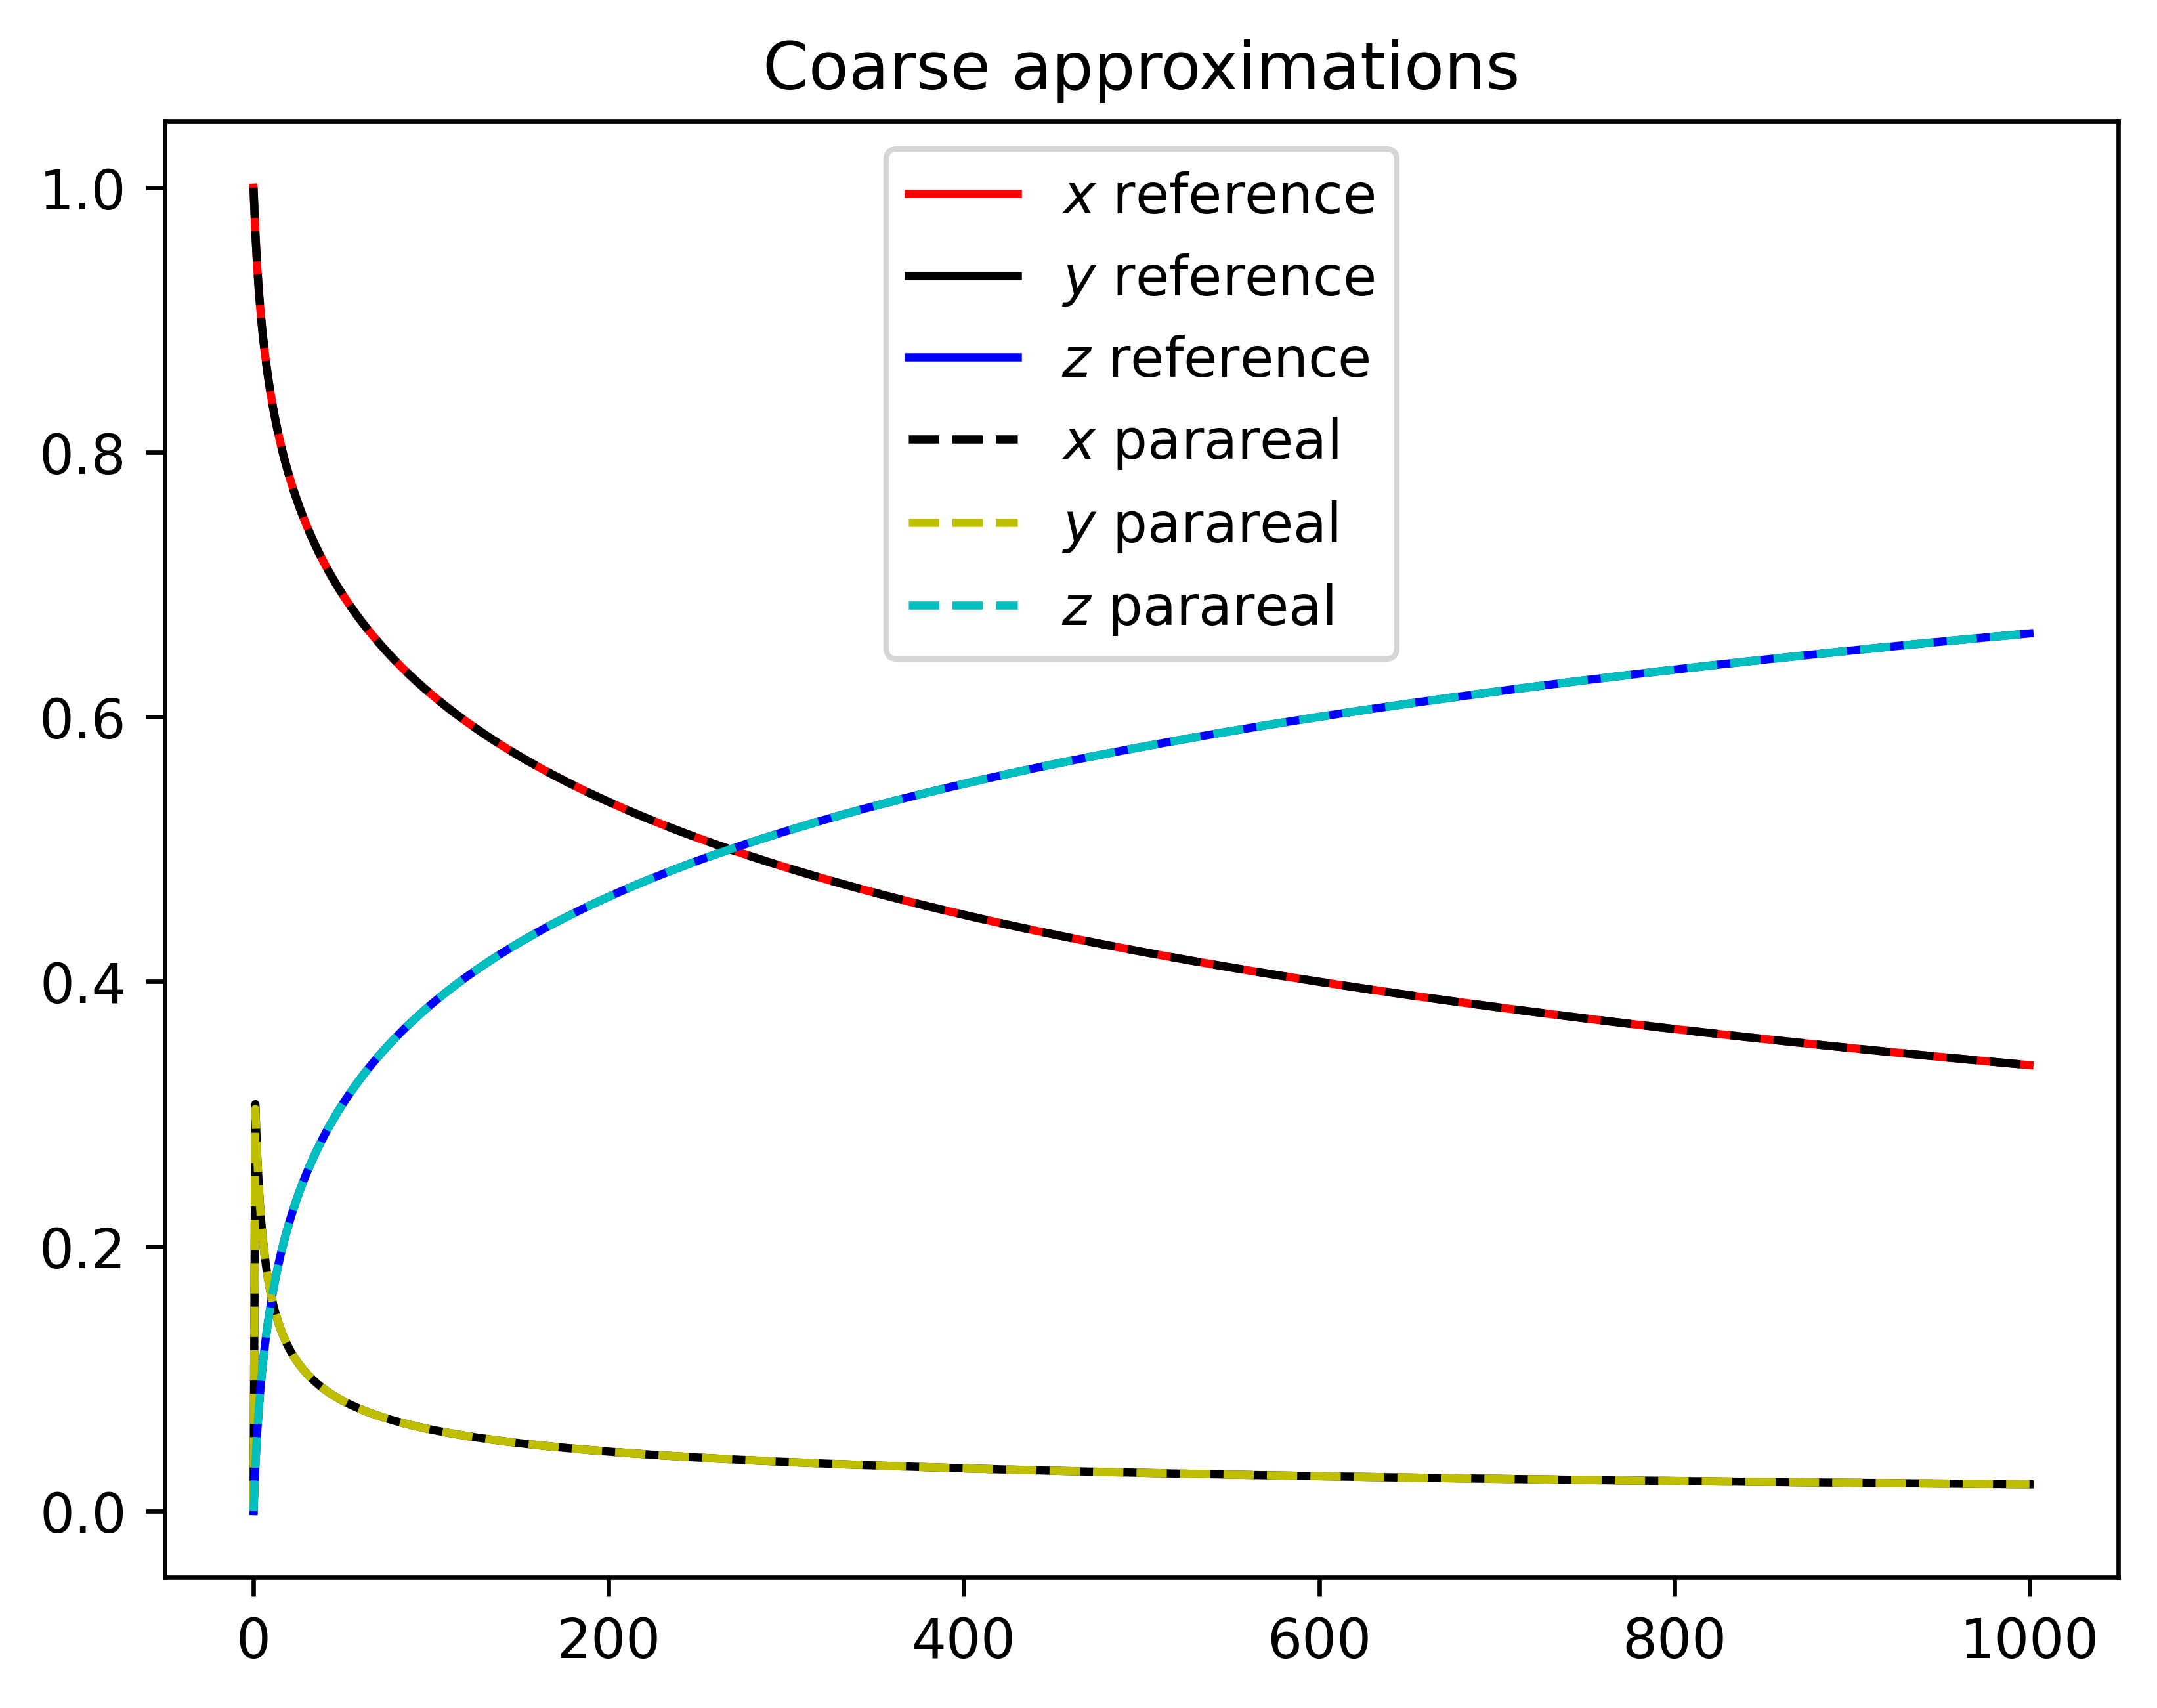

In [18]:
fig = plt.figure(dpi=600)

fact = 1e4*(system=="Rober") + 1. * (system=="SIR")
output, _ = lsoda(funcptr, y0, t_eval=t, rtol=1e-8, atol=1e-8)
plt.plot(t,output[:,0],'r-',label=r"$x$ reference")
plt.plot(t,output[:,1]*fact,'k-',label=r"$y$ reference")
plt.plot(t,output[:,2],'b-',label=r"$z$ reference")

plt.plot(t,coarse_values_parareal[:,0],'k--',label=r"$x$ parareal")
plt.plot(t,coarse_values_parareal[:,1]*fact,'y--',label=r"$y$ parareal")
plt.plot(t,coarse_values_parareal[:,2],'c--',label=r"$z$ parareal")
plt.legend()
plt.title("Coarse approximations")
plt.show();